## Create LSTM models to forecast depth to ground water
- Use multiple features to predict depth to groundwater

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, BatchNormalization, Dense, Dropout
from tensorflow.random import set_seed
from tensorflow.keras.regularizers import L1L2


2025-02-18 15:43:57.789372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 15:43:57.790250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 15:43:57.792688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 15:43:57.799462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 15:43:57.810098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Load preprocessed data

In [2]:
df = pd.read_csv("../Processed_data/processed_data.csv", index_col="Unnamed: 0")
keepcols = ["Rainfall","Depth_to_groundwater","Temperature","Drainage_Volume", "Hydrometry"]
df = df[keepcols]
df.head()

,Rainfall,Depth_to_groundwater,Temperature,Drainage_Volume,Hydrometry
0,0.0,-31.14,5.2,-24530.688,2.4
1,0.0,-31.11,2.3,-28785.888,2.5
2,0.0,-31.07,4.4,-25766.208,2.4
3,0.0,-31.05,0.8,-27919.296,2.4
4,0.0,-31.01,-1.9,-29854.656,2.3


## Use minmax scaler on Depth to groundwater

In [3]:
from sklearn.preprocessing import MinMaxScaler

### scale features
scaler = MinMaxScaler((-1,1))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Create another scaler that can invert the output
output_scaler = MinMaxScaler((-1,1))
output_scaler.fit(df[["Depth_to_groundwater"]])

MinMaxScaler(feature_range=(-1, 1))

## Parameters for the model

In [4]:
## set seed for reproducability
set_seed(5678)

### how many steps for future forecast
len_forecast = 10
look_back = 50
num_features = 5

## num folds
k = 10

### num nodes per layer
LSTM_layer1 = 64
LSTM_layer2 = 32
LSTM_layer3 = 32
Dense_layer1 = 32

Dropout_1 = 0.2
Dropout_2 = 0.2


## Create training and testing set

In [5]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = k)

## Process time series as input for LSTM
For LSTM, similar to any other supervised learning model we need labeled input data.
In this case, one training example is a subset of the time series, with the label being the following value.
For example, if we set the input length of our model to be 50 values, then an X_train would be the first 50 points of the time series, with y_train being the 51st value of the time series

In [6]:
def split_time_series_2D(sequence, num_features, num_steps):
    
    X = np.zeros(shape = (len(sequence) - num_steps - 1, num_features, num_steps))
    y = np.zeros(shape = len(sequence) - num_steps - 1)
        
    for i in range(len(sequence) - num_steps - 1):
        X[i] = sequence[i:i+num_steps].T
        
        try:
            y[i] = sequence.Depth_to_groundwater[i+num_steps]
        except:
            y[i] = sequence.Depth_to_groundwater.iloc[i+num_steps]
        
    return X, y

## Create training set
Create training set to train the model
Create holdout set to compare performance with ARIMA model

In [7]:
start_index = -len_forecast

X = None
y = None

for fold, (train_index, holdout_index) in enumerate(tscv.split(df_scaled)):
    train_sequence = train_index[start_index + len_forecast:]
    start_index = train_index[-1]
    
    split_sequence = df_scaled.loc[train_index]
    seqX, label = split_time_series_2D(split_sequence, num_features, look_back)
    
    

    try:
        X = np.concat([X,seqX])
        y = np.concat([y,label])
        
    except:
        X = seqX
        y = label


## Split samples into training and testing
- Xtrain & Xtest should have shape (num samples, num features, look_back)

- In our case we have 1 feature and look_back has been set to 50

In [8]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=1234)

## Add callback  to stop early

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 50,
    restore_best_weights=True)


## A note on overfitting
In previous iterations, the model had been overfitting, Various actions were taken to prevent this from happening
- Adding dropout layers. Strangely this increased overfitting.
- Regularizing the weights using L1 and L2 regularization. This performed quite well
- Time distributed batch normalization between LSTM layers
    - This slowed training, and model did not converged to a higher loss
- Tried Batchnormalization on input data, 
    - this significantly slowed training, and model converged to higher loss
- Add callback evaluated on validation loss, find model with the lowest validation loss

## Create the model

In [10]:
#### initialize the regularizer
reg1 = L1L2(l1 = 4e-5, l2 = 4e-5)

#### the model
model = Sequential()

#model.add(BatchNormalization(input_shape=(1, look_back)))         
model.add(LSTM(LSTM_layer1, activation='relu', return_sequences=True, input_shape=(num_features, look_back), kernel_regularizer=reg1))

model.add(LSTM(LSTM_layer2, activation='relu',return_sequences=True))
model.add(LSTM(LSTM_layer3, activation='relu'))

model.add(Dense(Dense_layer1, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

2025-02-18 15:44:03.597080: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-18 15:44:03.597107: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: Hotdog-Ubuntu
2025-02-18 15:44:03.597113: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: Hotdog-Ubuntu
2025-02-18 15:44:03.597268: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 470.256.2
2025-02-18 15:44:03.597284: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 470.256.2
2025-02-18 15:44:03.597288: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 470.256.2


## Fit the model

In [11]:
history = model.fit(Xtrain, ytrain,
                  validation_data=(Xtest, ytest),
                  epochs=500, 
                  callbacks=early_stop_callback,
                  verbose=2)

Epoch 1/500
106/106 - 3s - 24ms/step - loss: 0.0750 - val_loss: 0.0341
Epoch 2/500
106/106 - 0s - 3ms/step - loss: 0.0285 - val_loss: 0.0235
Epoch 3/500
106/106 - 0s - 3ms/step - loss: 0.0202 - val_loss: 0.0171
Epoch 4/500
106/106 - 0s - 3ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 5/500
106/106 - 0s - 3ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 6/500
106/106 - 0s - 3ms/step - loss: 0.0106 - val_loss: 0.0095
Epoch 7/500
106/106 - 0s - 3ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 8/500
106/106 - 0s - 3ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 9/500
106/106 - 0s - 3ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 10/500
106/106 - 0s - 3ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 11/500
106/106 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 12/500
106/106 - 0s - 3ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 13/500
106/106 - 0s - 3ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 14/500
106/106 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 15/500
1

106/106 - 0s - 3ms/step - loss: 5.3588e-04 - val_loss: 4.6707e-04
Epoch 111/500
106/106 - 0s - 3ms/step - loss: 5.4309e-04 - val_loss: 7.0407e-04
Epoch 112/500
106/106 - 0s - 3ms/step - loss: 6.4700e-04 - val_loss: 6.2543e-04
Epoch 113/500
106/106 - 0s - 3ms/step - loss: 5.2827e-04 - val_loss: 4.5890e-04
Epoch 114/500
106/106 - 0s - 3ms/step - loss: 5.3092e-04 - val_loss: 4.7278e-04
Epoch 115/500
106/106 - 0s - 3ms/step - loss: 5.8978e-04 - val_loss: 8.2169e-04
Epoch 116/500
106/106 - 0s - 3ms/step - loss: 9.1345e-04 - val_loss: 6.3732e-04
Epoch 117/500
106/106 - 0s - 3ms/step - loss: 4.8063e-04 - val_loss: 4.8836e-04
Epoch 118/500
106/106 - 0s - 3ms/step - loss: 5.0386e-04 - val_loss: 4.4770e-04
Epoch 119/500
106/106 - 0s - 3ms/step - loss: 4.8778e-04 - val_loss: 4.2890e-04
Epoch 120/500
106/106 - 0s - 3ms/step - loss: 5.5402e-04 - val_loss: 5.4173e-04
Epoch 121/500
106/106 - 0s - 3ms/step - loss: 5.0686e-04 - val_loss: 4.1797e-04
Epoch 122/500
106/106 - 0s - 3ms/step - loss: 4.8998e-

Epoch 213/500
106/106 - 0s - 3ms/step - loss: 3.7993e-04 - val_loss: 3.2764e-04
Epoch 214/500
106/106 - 0s - 3ms/step - loss: 3.6762e-04 - val_loss: 3.0356e-04
Epoch 215/500
106/106 - 0s - 3ms/step - loss: 3.7758e-04 - val_loss: 3.0217e-04
Epoch 216/500
106/106 - 0s - 3ms/step - loss: 4.0169e-04 - val_loss: 4.1132e-04
Epoch 217/500
106/106 - 0s - 3ms/step - loss: 4.2314e-04 - val_loss: 3.0898e-04
Epoch 218/500
106/106 - 0s - 3ms/step - loss: 3.8993e-04 - val_loss: 3.1106e-04
Epoch 219/500
106/106 - 0s - 3ms/step - loss: 4.0761e-04 - val_loss: 3.6347e-04
Epoch 220/500
106/106 - 0s - 3ms/step - loss: 4.4653e-04 - val_loss: 7.2212e-04
Epoch 221/500
106/106 - 0s - 3ms/step - loss: 4.2662e-04 - val_loss: 3.7783e-04
Epoch 222/500
106/106 - 0s - 3ms/step - loss: 3.6370e-04 - val_loss: 3.1303e-04
Epoch 223/500
106/106 - 0s - 3ms/step - loss: 3.7012e-04 - val_loss: 3.0481e-04
Epoch 224/500
106/106 - 0s - 3ms/step - loss: 3.8278e-04 - val_loss: 3.9276e-04
Epoch 225/500
106/106 - 0s - 3ms/step - 

## Plot traning & validation loss functions

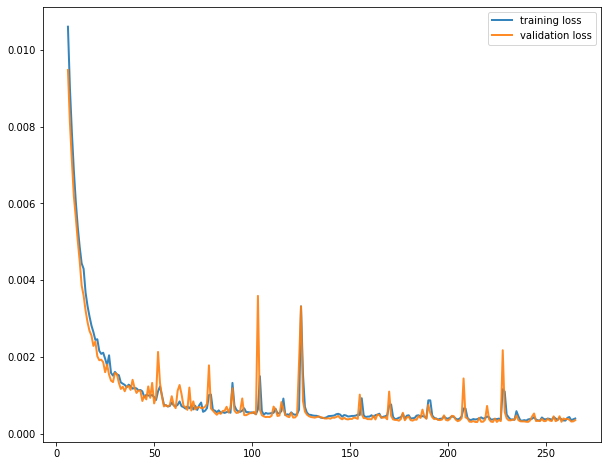

In [12]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = np.arange(1, len(train_loss) + 1)

skipstep = 5

plt.figure(figsize=(10,8))
plt.plot(epochs[skipstep:], train_loss[skipstep:], label = "training loss", linewidth = 2, alpha = 0.9)
plt.plot(epochs[skipstep:], val_loss[skipstep:], label = "validation loss", linewidth = 2, alpha = 0.9)

plt.legend()

# Look at performance of the model on the test set
- Evaluate predicting the next value
- We cannot predict 10 steps into the future with this model, since this would mean forecasting a value for the other features

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(380, 1)


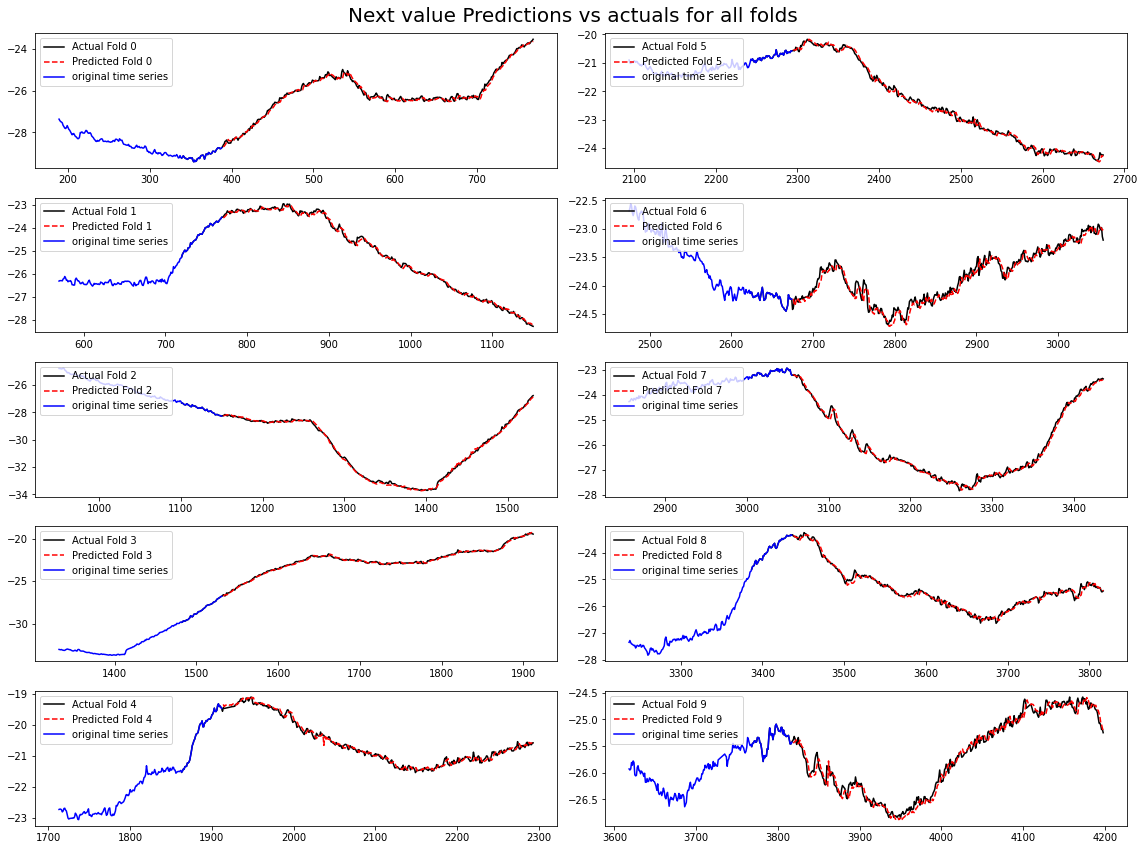

In [13]:
#fig, ax = plt.subplots(5,2, figsize = (16,12))

MSE_scores = []
MAE_scores = []

fig, ax = plt.subplots(5,2, figsize = (16,12))

for fold, (train_index, holdout_index) in enumerate(tscv.split(df_scaled)):
    
    ax2 = int(fold/5)
    ax1 = int(fold%5)
#     print(ax1, ax2)
    
    #### create holdout sets using split_time_series
    holdout_index = np.concatenate([np.arange(holdout_index[0]-look_back, holdout_index[0]), holdout_index])
    train, holdout = df_scaled.loc[train_index], df_scaled.loc[holdout_index]
        
    X_holdout, y_holdout = split_time_series_2D(holdout, num_features, look_back)
        
    #### generate models predictions
    predictions = model.predict(X_holdout)
    print(predictions.shape)
    ##scale back to normal
    predictions_inv = output_scaler.inverse_transform(predictions)
    
    ### get mse and mae
    mse = mean_squared_error(y_holdout, predictions_inv)
    mae = mean_absolute_error(y_holdout, predictions_inv)

    MSE_scores.append(mse)
    MAE_scores.append(mae)
    
    
    #### plot test and predicted
    ax[ax1, ax2].plot(holdout_index[:], df.Depth_to_groundwater[holdout_index[:]], color="black", label=f"Actual Fold {fold}")  # Test actuals
    ax[ax1, ax2].plot(holdout_index[look_back+1:], predictions_inv[:], color="red", linestyle="dashed", label=f"Predicted Fold {fold}")  # Predictions

    # Confidence interval shading
    #ax[ax1, ax2].fill_between(test_index[:10], upper_conf_trans, lower_conf_trans, color='red', alpha=0.2)
    ax[ax1, ax2].plot(train_index[-200:], df.Depth_to_groundwater[train_index[-200:]], color='blue', label ="original time series")
    ax[ax1, ax2].legend(loc="upper left")
    
fig.suptitle("Next value Predictions vs actuals for all folds", fontsize=20)
plt.tight_layout()

## Parameter tuning
- using grid search find optimal hyper parameter
- This will be evaluated on the test set, not the holdout set

- We will tune Units, L1, and L2,

In [14]:
def create_model(units, L1, L2):
    #### initialize the regularizer
    reg1 = L1L2(l1 = L1, l2 = L2)

    #### the model
    model = Sequential()

    #model.add(BatchNormalization(input_shape=(1, look_back)))         
    model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(num_features, look_back), kernel_regularizer=reg1))
    model.add(LSTM(int(units*0.5), activation='relu',return_sequences=True))
    model.add(LSTM(int(units*0.3), activation='relu'))

    model.add(Dense(Dense_layer1, activation = 'relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    
    return model

## Perform grid search
- Tried to use scikeras wrapper Kerasclassifier with sklearn.model_selection.GridSearchCV to perform the grid search, but this only worked for a specific set of parameters, (not *L1* and *L2*)
- Manually perform grid search by looping through all combinations
- Use Kfold cross validation to evaluate model performance on the training set

In [15]:
### define dictionary of search combinations
from itertools import product

param_grid = {
    'units' : [32, 64], 
    'L1' : [2e-5, 3e-5],
    'L2' : [2e-5, 3e-5],
}

param_names = param_grid.keys()
param_vals = param_grid.values()

combinations = [dict(zip(param_names, combo)) for combo in product(*param_vals)]

In [16]:
### define Kfolds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [17]:
model_val_loss = {}
best_model = None
best_loss = np.float16('inf')

for combo in combinations[:]:

    loss_vals = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        #### define training and validation data for each fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        ### initialize the callback
        early_stop_callback = EarlyStopping(
                                    monitor = 'val_loss',
                                    patience = 50,
                                    restore_best_weights=True)
        
        ## define model, redefine for every fold so the weights are reset
        ## model parameters defined by combo
        model = create_model(combo['units'],combo['L1'],combo['L2'])

        
        ## fit model to data for given fold
        history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=500, 
                              callbacks=early_stop_callback,
                              verbose=0)
        
        ### use validation loss as performance metric
        loss_vals.append(min(history.history["val_loss"]))
    
    ### get the average validation loss for a parameter selection
    mean_loss = np.mean(loss_vals) 
    model_val_loss[str(combo)] = mean_loss
    
    print(combo, np.mean(loss_vals))
    
    ## if its the best model, save it
    if mean_loss < best_loss:
        print("new best model")
        best_loss = mean_loss
        best_model = model

{'units': 32, 'L1': 2e-05, 'L2': 2e-05} 0.00029461430967785417
new best model
{'units': 32, 'L1': 2e-05, 'L2': 3e-05} 0.00020899268856737762
new best model
{'units': 32, 'L1': 3e-05, 'L2': 2e-05} 0.00020553789508994668
new best model
{'units': 32, 'L1': 3e-05, 'L2': 3e-05} 0.00022484402579721064
{'units': 64, 'L1': 2e-05, 'L2': 2e-05} 0.0002304901834577322
{'units': 64, 'L1': 2e-05, 'L2': 3e-05} 0.00020918179652653634
{'units': 64, 'L1': 3e-05, 'L2': 2e-05} 0.00021699841890949757
{'units': 64, 'L1': 3e-05, 'L2': 3e-05} 0.00027179884491488335


## Model with best parameters
- Best model has parameters:
- Units = 32
    - LSTM1 has 32 LSTM cells
    - LSTM2 has 16 LSTM cells
    - LSTM3 has 9 LSTM cells
- L1 = 3e-5
- L2 = 2e-5

In [18]:
##  sort dictionary based on validation loss
sorted(model_val_loss.items(), key = lambda x:x[1])

[("{'units': 32, 'L1': 3e-05, 'L2': 2e-05}", 0.00020553789508994668),
 ("{'units': 32, 'L1': 2e-05, 'L2': 3e-05}", 0.00020899268856737762),
 ("{'units': 64, 'L1': 2e-05, 'L2': 3e-05}", 0.00020918179652653634),
 ("{'units': 64, 'L1': 3e-05, 'L2': 2e-05}", 0.00021699841890949757),
 ("{'units': 32, 'L1': 3e-05, 'L2': 3e-05}", 0.00022484402579721064),
 ("{'units': 64, 'L1': 2e-05, 'L2': 2e-05}", 0.0002304901834577322),
 ("{'units': 64, 'L1': 3e-05, 'L2': 3e-05}", 0.00027179884491488335),
 ("{'units': 32, 'L1': 2e-05, 'L2': 2e-05}", 0.00029461430967785417)]

## Train model with best parameters

In [19]:
### best params
units = 32
L1 = 3e-5
L2 = 2e-5

early_stop_callback = EarlyStopping(
                            monitor = 'val_loss',
                            patience = 50,
                            restore_best_weights=True)

model = create_model(units, L1, L2)

## fit model to data for given fold
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=500, 
                      callbacks=early_stop_callback,
                      verbose=1)

model.save('./Models/LSTM_5featurea.keras')

Epoch 1/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1514 - val_loss: 0.0321
Epoch 2/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.0177
Epoch 3/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 4/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0116
Epoch 5/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 6/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 7/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 8/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 9/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 10/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 11/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 12/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

Epoch 69/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1070e-04 - val_loss: 7.9185e-04
Epoch 70/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4457e-04 - val_loss: 9.3437e-04
Epoch 71/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4328e-04 - val_loss: 7.6332e-04
Epoch 72/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9385e-04 - val_loss: 7.6356e-04
Epoch 73/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9953e-04 - val_loss: 7.9851e-04
Epoch 74/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9960e-04 - val_loss: 8.0338e-04
Epoch 75/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6451e-04 - val_loss: 8.8718e-04
Epoch 76/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8311e-04 - val_loss: 8.0423e-04
Epoch 77/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6378e-04 - val_loss: 7.2608e-04
Epoch 78/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5756e-04 - val_loss: 8.2437e-04
Epoch 79/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5533e-04 - val_loss: 5.7599e-04
Epoch 133/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7157e-04 - val_loss: 6.5677e-04
Epoch 134/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1996e-04 - val_loss: 7.9386e-04
Epoch 135/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8604e-04 - val_loss: 5.1168e-04
Epoch 136/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1963e-04 - val_loss: 5.0099e-04
Epoch 137/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2562e-04 - val_loss: 4.8721e-04
Epoch 138/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9976e-04 - val_loss: 6.2029e-04
Epoch 139/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5394e-04 - val_loss: 4.5218e-04
Epoch 140/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3084e-04 - val_loss: 5.4741e-04
Epoch 141/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7495e-04 - val_loss: 4.4585e-04
Epoch 142/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5117e-04 - val_loss: 3.7657e-04
Epoch 196/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2130e-04 - val_loss: 4.3121e-04
Epoch 197/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4333e-04 - val_loss: 4.3603e-04
Epoch 198/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1188e-04 - val_loss: 3.8604e-04
Epoch 199/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2086e-04 - val_loss: 4.7235e-04
Epoch 200/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0644e-04 - val_loss: 3.6774e-04
Epoch 201/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9581e-04 - val_loss: 3.6505e-04
Epoch 202/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8911e-04 - val_loss: 3.5775e-04
Epoch 203/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8656e-04 - val_loss: 3.5425e-04
Epoch 204/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8400e-04 - val_loss: 3.8086e-04
Epoch 205/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1779e-04 - val_loss: 3.4037e-04
Epoch 259/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9055e-04 - val_loss: 3.3497e-04
Epoch 260/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6945e-04 - val_loss: 3.2941e-04
Epoch 261/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3944e-04 - val_loss: 3.5038e-04
Epoch 262/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8448e-04 - val_loss: 3.6632e-04
Epoch 263/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9309e-04 - val_loss: 3.5384e-04
Epoch 264/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8793e-04 - val_loss: 3.3458e-04
Epoch 265/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8607e-04 - val_loss: 3.5174e-04
Epoch 266/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3351e-04 - val_loss: 3.9551e-04
Epoch 267/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3809e-04 - val_loss: 3.8223e-04
Epoch 268/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8231e-04 - val_loss: 3.0526e-04
Epoch 322/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5110e-04 - val_loss: 3.1795e-04
Epoch 323/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4061e-04 - val_loss: 2.9272e-04
Epoch 324/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3111e-04 - val_loss: 3.3924e-04
Epoch 325/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4685e-04 - val_loss: 2.8141e-04
Epoch 326/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2074e-04 - val_loss: 3.8718e-04
Epoch 327/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7699e-04 - val_loss: 2.9558e-04
Epoch 328/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2467e-04 - val_loss: 3.2906e-04
Epoch 329/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6839e-04 - val_loss: 2.7218e-04
Epoch 330/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0328e-04 - val_loss: 3.4713e-04
Epoch 331/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9770e-04 - val_loss: 6.1105e-04
Epoch 385/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8012e-04 - val_loss: 2.9078e-04
Epoch 386/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1733e-04 - val_loss: 2.5334e-04
Epoch 387/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8545e-04 - val_loss: 2.6865e-04
Epoch 388/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7782e-04 - val_loss: 2.5826e-04
Epoch 389/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8545e-04 - val_loss: 2.5776e-04
Epoch 390/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2872e-04 - val_loss: 4.2510e-04
Epoch 391/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6601e-04 - val_loss: 2.5511e-04
Epoch 392/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4629e-04 - val_loss: 5.0019e-04
Epoch 393/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1738e-04 - val_loss: 3.2491e-04
Epoch 394/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0932e-04 - val_loss: 2.5568e-04
Epoch 448/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8839e-04 - val_loss: 2.5323e-04
Epoch 449/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1353e-04 - val_loss: 2.9273e-04
Epoch 450/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1305e-04 - val_loss: 2.8578e-04
Epoch 451/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6273e-04 - val_loss: 2.5106e-04
Epoch 452/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7677e-04 - val_loss: 2.6981e-04
Epoch 453/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1865e-04 - val_loss: 2.6712e-04
Epoch 454/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1276e-04 - val_loss: 4.1922e-04
Epoch 455/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0627e-04 - val_loss: 2.5052e-04
Epoch 456/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8231e-04 - val_loss: 2.8773e-04
Epoch 457/500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3

In [20]:
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_123 (LSTM)                 │ (None, 5, 32)          │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_124 (LSTM)                 │ (None, 5, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ (None, 9)              │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,149 (176.37 KB)

 Trainable params: 15,049 (58.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,100 (117.58 KB)